<a href="https://colab.research.google.com/github/ankit-kothari/Data-Science-Journey/blob/transformers_lp_course/sentiment_analysis_fine_tuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [63]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Sun Jun  5 18:51:48 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   49C    P0    36W / 250W |   3759MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [64]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 54.8 gigabytes of available RAM

You are using a high-RAM runtime!


In [65]:
!pip install datasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [66]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [67]:
!pip3 install torchinfo

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [68]:
import transformers 
import  matplotlib.pyplot as plt
from datasets import load_dataset
import numpy as np 
import pandas as pd 
from pprint import pprint
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, f1_score, precision_score, recall_score,roc_auc_score,accuracy_score
from sklearn.metrics import plot_confusion_matrix,classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from datasets import load_metric


## Datasets

In [69]:
raw_datasets = load_dataset("glue","sst2")


Reusing dataset glue (/root/.cache/huggingface/datasets/glue/sst2/1.0.0/dacbe3125aa31d7f70367a07a8a9e72a5a0bfeb5fc42e75c9db75b96da6053ad)


  0%|          | 0/3 [00:00<?, ?it/s]

In [70]:
raw_datasets

DatasetDict({
    train: Dataset({
        features: ['sentence', 'label', 'idx'],
        num_rows: 67349
    })
    validation: Dataset({
        features: ['sentence', 'label', 'idx'],
        num_rows: 872
    })
    test: Dataset({
        features: ['sentence', 'label', 'idx'],
        num_rows: 1821
    })
})

In [71]:
print(raw_datasets['train'])
print(dir(raw_datasets['train']))

Dataset({
    features: ['sentence', 'label', 'idx'],
    num_rows: 67349
})
['_TF_DATASET_REFS', '__class__', '__del__', '__delattr__', '__dict__', '__dir__', '__doc__', '__enter__', '__eq__', '__exit__', '__format__', '__ge__', '__getattribute__', '__getitem__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__iter__', '__le__', '__len__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__slotnames__', '__str__', '__subclasshook__', '__weakref__', '_build_local_temp_path', '_check_index_is_initialized', '_data', '_fingerprint', '_format_columns', '_format_kwargs', '_format_type', '_get_cache_file_path', '_get_output_signature', '_getitem', '_indexes', '_indices', '_info', '_iter', '_map_single', '_new_dataset_with_indices', '_output_all_columns', '_push_parquet_shards_to_hub', '_split', 'add_column', 'add_elasticsearch_index', 'add_faiss_index', 'add_faiss_index_from_external_arrays', 'add_item', 'align_la

In [72]:
type(raw_datasets['train'])

datasets.arrow_dataset.Dataset

In [73]:
raw_datasets['train'].data

MemoryMappedTable
sentence: string
label: int64
idx: int32
----
sentence: [["hide new secretions from the parental units ","contains no wit , only labored gags ","that loves its characters and communicates something rather beautiful about human nature ","remains utterly satisfied to remain the same throughout ","on the worst revenge-of-the-nerds clichés the filmmakers could dredge up ","that 's far too tragic to merit such superficial treatment ","demonstrates that the director of such hollywood blockbusters as patriot games can still turn out a small , personal film with an emotional wallop . ","of saucy ","a depressed fifteen-year-old 's suicidal poetry ","are more deeply thought through than in most ` right-thinking ' films ",...,"sealed with a kiss ","very ugly ","why this project was undertaken ","the mill sci-fi film with a flimsy ending and ","halfhearted ","dilutes the pleasure of watching them ","the emotion is impressively true for being so hot-blooded , and ","can get your m

In [74]:
raw_datasets['train'][0]

{'idx': 0,
 'label': 0,
 'sentence': 'hide new secretions from the parental units '}

In [75]:
raw_datasets['train'][50000:50003]

{'idx': [50000, 50001, 50002],
 'label': [1, 1, 1],
 'sentence': ['glow ',
  'a classical dramatic animated feature ',
  'best espionage picture ']}

In [76]:
raw_datasets['train'].features

{'idx': Value(dtype='int32', id=None),
 'label': ClassLabel(num_classes=2, names=['negative', 'positive'], id=None),
 'sentence': Value(dtype='string', id=None)}

In [77]:
len(raw_datasets['train'])

67349

In [78]:
raw_datasets['train'].column_names

['sentence', 'label', 'idx']

In [79]:
raw_datasets['train']['sentence'][:5]

['hide new secretions from the parental units ',
 'contains no wit , only labored gags ',
 'that loves its characters and communicates something rather beautiful about human nature ',
 'remains utterly satisfied to remain the same throughout ',
 'on the worst revenge-of-the-nerds clichés the filmmakers could dredge up ']

##From Datasets to DataFrame


In [80]:
raw_datasets.set_format(type='pandas')
tweet_data = raw_datasets['train'][:]

In [81]:

int2str_label = raw_datasets['train'].features['label'].names
int2str_mapping = {k:v for k,v in enumerate(int2str_label)}
int2str_mapping

{0: 'negative', 1: 'positive'}

In [82]:
%%timeit
tweet_data['label_name']= tweet_data['label'].map(int2str_mapping)

1000 loops, best of 5: 1.97 ms per loop


In [83]:
tweet_data.head()

,sentence,label,idx,label_name
0,hide new secretions from the parental units,0,0,negative
1,"contains no wit , only labored gags",0,1,negative
2,that loves its characters and communicates som...,1,2,positive
3,remains utterly satisfied to remain the same t...,0,3,negative
4,on the worst revenge-of-the-nerds clichés the ...,0,4,negative


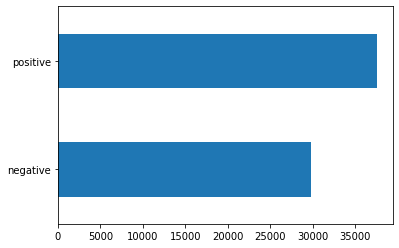

In [84]:
tweet_data['label_name'].value_counts(ascending=True).plot.barh()

/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


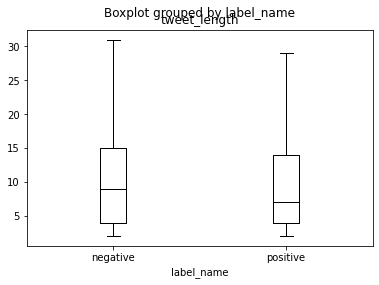

In [85]:
tweet_data['tweet_length']= tweet_data['sentence'].apply(lambda x: len(x.split(' ')))
tweet_data.boxplot("tweet_length", by="label_name", color="black",grid=False, showfliers=False)

In [86]:
tweet_data.groupby(['label_name'])['tweet_length'].describe()

,count,mean,std,min,25%,50%,75%,max
label_name,,,,,,,,
negative,29780.0,10.882874,8.157512,2.0,4.0,9.0,15.0,53.0
positive,37569.0,10.034363,7.987037,2.0,4.0,7.0,14.0,53.0


In [87]:
raw_datasets.reset_format()

## From Text to Tokenization


In [88]:
from transformers import AutoTokenizer

In [89]:
checkpoint = 'distilbert-base-uncased'
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

### Text Tokens to Integer Ids

In [90]:
tokenized_sentences = tokenizer(raw_datasets['train'][0:3]['sentence'])
pprint(tokenized_sentences)

{'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
                    [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
                    [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]],
 'input_ids': [[101, 5342, 2047, 3595, 8496, 2013, 1996, 18643, 3197, 102],
               [101,
                3397,
                2053,
                15966,
                1010,
                2069,
                4450,
                2098,
                18201,
                2015,
                102],
               [101,
                2008,
                7459,
                2049,
                3494,
                1998,
                10639,
                2015,
                2242,
                2738,
                3376,
                2055,
                2529,
                3267,
                102]]}


### Integer Ids to Tokens

In [91]:
back2tokens = tokenizer.convert_ids_to_tokens(tokenized_sentences['input_ids'][0])
back2tokens

['[CLS]',
 'hide',
 'new',
 'secret',
 '##ions',
 'from',
 'the',
 'parental',
 'units',
 '[SEP]']

In [92]:
print(tokenizer.convert_tokens_to_string(back2tokens))

[CLS] hide new secretions from the parental units [SEP]


### Tokenization the entire dataset

In [93]:
def tokenize_fn(batch):
  return tokenizer(batch['sentence'], truncation=True,padding=True)

tokenized_dataset = raw_datasets.map(tokenize_fn, batched=True)

Loading cached processed dataset at /root/.cache/huggingface/datasets/glue/sst2/1.0.0/dacbe3125aa31d7f70367a07a8a9e72a5a0bfeb5fc42e75c9db75b96da6053ad/cache-c6e71d05afb55ca6.arrow


  0%|          | 0/1 [00:00<?, ?ba/s]

Loading cached processed dataset at /root/.cache/huggingface/datasets/glue/sst2/1.0.0/dacbe3125aa31d7f70367a07a8a9e72a5a0bfeb5fc42e75c9db75b96da6053ad/cache-429c3afbc7935684.arrow


In [94]:
tokenized_dataset

DatasetDict({
    train: Dataset({
        features: ['sentence', 'label', 'idx', 'input_ids', 'attention_mask'],
        num_rows: 67349
    })
    validation: Dataset({
        features: ['sentence', 'label', 'idx', 'input_ids', 'attention_mask'],
        num_rows: 872
    })
    test: Dataset({
        features: ['sentence', 'label', 'idx', 'input_ids', 'attention_mask'],
        num_rows: 1821
    })
})

In [95]:
pprint(tokenize_fn(raw_datasets['train'][:3]))

{'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0],
                    [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0],
                    [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]],
 'input_ids': [[101,
                5342,
                2047,
                3595,
                8496,
                2013,
                1996,
                18643,
                3197,
                102,
                0,
                0,
                0,
                0,
                0],
               [101,
                3397,
                2053,
                15966,
                1010,
                2069,
                4450,
                2098,
                18201,
                2015,
                102,
                0,
                0,
                0,
                0],
               [101,
                2008,
                7459,
                2049,
                3494,
                1998,
                10639,
          

###Fine Tuning
- Getting the pre_trained model
- All the parameters will be trained with a very slow learning rate. 

### Training Arguments

In [96]:
from transformers import TrainingArguments

In [97]:
from transformers import training_args
batch_size= 64
logging_steps = len(tokenized_dataset["train"]) // batch_size
model_name = "airline_tweet_analysis_model"
training_args = TrainingArguments(
    'airline_tweet_lp',
    evaluation_strategy='epoch',
    num_train_epochs=2,
    learning_rate=2e-5,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    save_strategy='epoch',
    logging_steps=logging_steps,
    log_level="error",
    push_to_hub=False,
    disable_tqdm=False
    )

In [98]:
from transformers import AutoModelForSequenceClassification
import torch
model_ckpt =  'distilbert-base-uncased'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_labels=2



In [99]:
model = (AutoModelForSequenceClassification.from_pretrained(model_ckpt, num_labels=num_labels).to(device))

In [100]:
model

DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0): TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
       

In [101]:
type(model)

transformers.models.distilbert.modeling_distilbert.DistilBertForSequenceClassification

In [102]:
#from torchinfo import summary
#summary(model,input_size=(batch_size,512), dtypes=['torch.IntTensor'],device='cpu')
#summary(model)

In [103]:
params_before = []
for name, p in model.named_parameters():
  print(name,p.shape)
  params_before.append(p.detach().cpu().numpy())

distilbert.embeddings.word_embeddings.weight torch.Size([30522, 768])
distilbert.embeddings.position_embeddings.weight torch.Size([512, 768])
distilbert.embeddings.LayerNorm.weight torch.Size([768])
distilbert.embeddings.LayerNorm.bias torch.Size([768])
distilbert.transformer.layer.0.attention.q_lin.weight torch.Size([768, 768])
distilbert.transformer.layer.0.attention.q_lin.bias torch.Size([768])
distilbert.transformer.layer.0.attention.k_lin.weight torch.Size([768, 768])
distilbert.transformer.layer.0.attention.k_lin.bias torch.Size([768])
distilbert.transformer.layer.0.attention.v_lin.weight torch.Size([768, 768])
distilbert.transformer.layer.0.attention.v_lin.bias torch.Size([768])
distilbert.transformer.layer.0.attention.out_lin.weight torch.Size([768, 768])
distilbert.transformer.layer.0.attention.out_lin.bias torch.Size([768])
distilbert.transformer.layer.0.sa_layer_norm.weight torch.Size([768])
distilbert.transformer.layer.0.sa_layer_norm.bias torch.Size([768])
distilbert.trans

In [104]:
def compute_metrics(pred):
  labels=pred.label_ids
  preds = pred.predictions.argmax(-1)
  f1 = f1_score(labels,preds, average="weighted"),
  acc = accuracy_score(labels,preds)
  return {"accuracy":acc,"f1":f1}



In [105]:
metric = load_metric("glue","sst2")

In [106]:
metric.compute(predictions=[1,0,1], references=[1,0,1])

{'accuracy': 1.0}

## Trainer

In [107]:
from transformers import Trainer 
trainer = Trainer(model=model, args=training_args,
                  compute_metrics=compute_metrics,
                  train_dataset=tokenized_dataset['train'],
                  eval_dataset = tokenized_dataset['validation'],
                  tokenizer=tokenizer)

In [108]:
trainer.train()

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.236200,0.257731,0.904817,"(0.9048183919899616,)"
2,0.125600,0.278514,0.903670,"(0.9036367570099241,)"


TrainOutput(global_step=2106, training_loss=0.18078272737357465, metrics={'train_runtime': 451.5784, 'train_samples_per_second': 298.283, 'train_steps_per_second': 4.664, 'total_flos': 2293899133717752.0, 'train_loss': 0.18078272737357465, 'epoch': 2.0})

In [109]:
pred_outputs = trainer.predict(tokenized_dataset['validation'])

In [110]:
pred_outputs.metrics

{'test_accuracy': 0.9036697247706422,
 'test_f1': (0.9036367570099241,),
 'test_loss': 0.2785138487815857,
 'test_runtime': 0.9042,
 'test_samples_per_second': 964.339,
 'test_steps_per_second': 15.483}

In [111]:
y_preds = np.argmax(pred_outputs.predictions,axis=1)

In [112]:
y_valid = np.array(tokenized_dataset['validation']["label"])

In [113]:
labels = tokenized_dataset["train"].features["label"].names

In [114]:
cm = confusion_matrix(y_valid, y_preds, labels=[0,1])

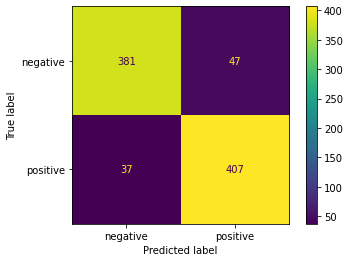

In [115]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                             display_labels=['negative', 'positive'])
disp.plot()
plt.grid(False)
plt.show()

##Saving the model

In [116]:
trainer.save_model('my_saved_model')

In [117]:
!ls

airline_tweet_lp  my_saved_model  sample_data


In [118]:
from transformers import pipeline

In [119]:
newmodel = pipeline('text-classification',model='my_saved_model',device=0)

In [120]:
newmodel('this airline does not give any good meal')

[{'label': 'LABEL_0', 'score': 0.9968542456626892}]

In [121]:
newmodel('i think this airline would have been good if they had inflight entertainement')

[{'label': 'LABEL_0', 'score': 0.8676590323448181}]

In [122]:
newmodel('this flight was peace')

[{'label': 'LABEL_1', 'score': 0.9888142943382263}]

In [123]:
model

DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0): TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
       

In [124]:
!cat my_saved_model/config.json

{
  "_name_or_path": "distilbert-base-uncased",
  "activation": "gelu",
  "architectures": [
    "DistilBertForSequenceClassification"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "initializer_range": 0.02,
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "pad_token_id": 0,
  "problem_type": "single_label_classification",
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "torch_dtype": "float32",
  "transformers_version": "4.19.2",
  "vocab_size": 30522
}


In [125]:
import json 
config_path = 'my_saved_model/config.json'

In [127]:
with open(config_path) as f:
  j = json.load(f)

j['id2label']={0: 'negative', 1: 'positive'}

with open(config_path,'w') as f:
  json.dump(j,f,indent=2)

In [128]:
!cat my_saved_model/config.json

{
  "_name_or_path": "distilbert-base-uncased",
  "activation": "gelu",
  "architectures": [
    "DistilBertForSequenceClassification"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "initializer_range": 0.02,
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "pad_token_id": 0,
  "problem_type": "single_label_classification",
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "torch_dtype": "float32",
  "transformers_version": "4.19.2",
  "vocab_size": 30522,
  "id2label": {
    "0": "negative",
    "1": "positive"
  }
}

In [129]:
newmodel = pipeline('text-classification',model='my_saved_model',device=0)
newmodel('this airline does not give any good meal')

[{'label': 'negative', 'score': 0.9968542456626892}]

In [131]:
params_after = []
for name,p in model.named_parameters():
  params_after.append(p.detach().cpu().numpy())

In [132]:
for p1,p2 in zip(params_before,params_after):
  print(np.sum(np.abs(p1-p2)))

4295.8564
22.397516
0.42992195
0.37554002
315.29938
0.44935855
310.2603
0.0003125943
314.87762
0.36486322
294.90582
0.28997904
0.4074064
0.2932126
1264.9528
1.5678885
1179.0743
0.2436764
0.39350107
0.24740562
312.3826
0.38964438
307.3603
0.0002814801
277.76935
0.27510706
259.61444
0.23003757
0.36502448
0.22532144
1265.5698
1.4621453
1131.4347
0.22013886
0.38440046
0.23639287
314.73383
0.3718079
316.68652
0.0002969986
278.59503
0.25877658
271.8359
0.22087382
0.3821654
0.22072417
1320.4331
1.5025897
1137.2251
0.2309854
0.39983714
0.22972032
347.77847
0.44709066
348.8623
0.00033897278
319.97488
0.2544848
312.5946
0.24171343
0.3905411
0.2387199
1357.4976
1.6211772
1159.6282
0.2905829
0.40575072
0.2863285
349.1933
0.45537767
353.37854
0.00024720648
299.25183
0.2886273
321.3755
0.3158031
0.39768344
0.3406638
1339.9982
1.5978796
1068.1765
0.2795648
0.41227633
0.28192323
345.38422
0.4643112
341.55566
0.00011034015
323.89346
0.27253997
355.9033
0.2883676
0.4718718
0.34186974
1341.129
1.6796286
